In [1]:
"""
TP8: PySOT Object Tracking - Complete Implementation for Kaggle
================================================================
This notebook implements object tracking using PySOT (SiamRPN++) with OpenCV fallback.
Optimized for Kaggle environment with GPU support.

Author: MOHAMMED ELIDRISSI LAOUKILI
"""

'\nTP8: PySOT Object Tracking - Complete Implementation for Kaggle\n================================================================\nThis notebook implements object tracking using PySOT (SiamRPN++) with OpenCV fallback.\nOptimized for Kaggle environment with GPU support.\n\nAuthor: MOHAMMED ELIDRISSI LAOUKILI\n'

In [2]:
# ============================================================================
# PART 1: ENVIRONMENT SETUP
# ============================================================================
print("="*80)
print("TP8 - OBJECT TRACKING WITH PYSOT")
print("="*80)

import os
import sys
import subprocess
from pathlib import Path

# Kaggle working directory
WORK_DIR = '/kaggle/working'
os.makedirs(WORK_DIR, exist_ok=True)
print(f"\n✓ Working directory: {WORK_DIR}")

TP8 - OBJECT TRACKING WITH PYSOT

✓ Working directory: /kaggle/working


In [3]:
# ============================================================================
# PART 2: INSTALL DEPENDENCIES
# ============================================================================
print("\n[1/10] Installing dependencies...")

dependencies = [
    'opencv-contrib-python',
    'pyyaml',
    'yacs',
    'tqdm',
    'colorama',
    'gdown',
    'cython',
]

for pkg in dependencies:
    subprocess.run([sys.executable, '-m', 'pip', 'install', '-q', pkg], 
                   check=False)

print("✓ Dependencies installed")


[1/10] Installing dependencies...
✓ Dependencies installed


In [4]:
# ============================================================================
# PART 3: VERIFY GPU
# ============================================================================
print("\n[2/10] Checking GPU availability...")

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    device = 'cuda'
else:
    print("⚠ GPU not available, using CPU")
    device = 'cpu'


[2/10] Checking GPU availability...
PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4
CUDA version: 12.6


In [5]:
# ============================================================================
# PART 4: CLONE PYSOT REPOSITORY
# ============================================================================
print("\n[3/10] Cloning PySOT repository...")

os.chdir('/kaggle/working')

if Path('/kaggle/working/pysot').exists():
    print("Removing old PySOT installation...")
    subprocess.run(['rm', '-rf', '/kaggle/working/pysot'], check=False)

subprocess.run(['git', 'clone', 'https://github.com/STVIR/pysot.git'], 
               check=True)
os.chdir('/kaggle/working/pysot')
print("✓ PySOT cloned successfully")


[3/10] Cloning PySOT repository...


Cloning into 'pysot'...


✓ PySOT cloned successfully


In [6]:
# ============================================================================
# PART 5: FIX CYTHON FILES
# ============================================================================
print("\n[4/10] Fixing Cython compatibility issues...")

# Create missing c_region.pxd file
c_region_pxd = """# cython: language_level=3

cdef extern from "region.h":
    ctypedef struct region_bounds:
        float top
        float bottom
        float left
        float right

    ctypedef struct region_rectangle:
        float x
        float y
        float width
        float height

    ctypedef struct region_polygon:
        int count
        float *x
        float *y

    float compute_polygon_overlap(region_polygon *polygon1,
                                   region_polygon *polygon2,
                                   region_bounds bounds)
"""

utils_dir = Path('toolkit/utils')
utils_dir.mkdir(parents=True, exist_ok=True)

with open(utils_dir / 'c_region.pxd', 'w') as f:
    f.write(c_region_pxd)
print("✓ Created c_region.pxd")

# Fix region.pyx for Python 3
region_pyx = utils_dir / 'region.pyx'
if region_pyx.exists():
    content = region_pyx.read_text()
    if '# cython: language_level=3' not in content:
        content = '# cython: language_level=3\n' + content
        region_pyx.write_text(content)
        print("✓ Fixed region.pyx for Python 3")


[4/10] Fixing Cython compatibility issues...
✓ Created c_region.pxd
✓ Fixed region.pyx for Python 3


In [7]:
# ============================================================================
# PART 6: COMPILE CYTHON EXTENSIONS
# ============================================================================
print("\n[5/10] Compiling Cython extensions...")

subprocess.run([sys.executable, 'setup.py', 'build_ext', '--inplace'], 
               capture_output=True, check=False)

# Configure Python path
sys.path.insert(0, '/kaggle/working/pysot')
os.environ['PYTHONPATH'] = '/kaggle/working/pysot'
print("✓ Cython extensions compiled (warnings are normal)")


[5/10] Compiling Cython extensions...
✓ Cython extensions compiled (warnings are normal)


In [8]:
# ============================================================================
# PART 7: DOWNLOAD PRE-TRAINED MODEL
# ============================================================================
print("\n[6/10] Downloading SiamRPN++ pre-trained model (207 MB)...")

exp_dir = Path('/kaggle/working/pysot/experiments/siamrpn_r50_l234_dwxcorr')
exp_dir.mkdir(parents=True, exist_ok=True)

model_path = exp_dir / 'model.pth'

if not model_path.exists():
    import gdown
    url = 'https://drive.google.com/uc?id=1xoebTW6NLzdZGEYfu4jJb5BXxcY7xvx2'
    gdown.download(url, str(model_path), quiet=False)
    
    if model_path.exists():
        size_mb = model_path.stat().st_size / (1024*1024)
        print(f"✓ Model downloaded: {size_mb:.2f} MB")
    else:
        print("⚠ Model download failed")
else:
    print("✓ Model already exists")



[6/10] Downloading SiamRPN++ pre-trained model (207 MB)...


Downloading...
From (original): https://drive.google.com/uc?id=1xoebTW6NLzdZGEYfu4jJb5BXxcY7xvx2
From (redirected): https://drive.google.com/uc?id=1xoebTW6NLzdZGEYfu4jJb5BXxcY7xvx2&confirm=t&uuid=16ecbc83-4cdc-4a76-9762-c13d24528d97
To: /kaggle/working/pysot/experiments/siamrpn_r50_l234_dwxcorr/model.pth
100%|██████████| 216M/216M [00:01<00:00, 139MB/s]  

✓ Model downloaded: 206.11 MB


In [9]:
# ============================================================================
# PART 8: DOWNLOAD TEST VIDEO
# ============================================================================
print("\n[7/10] Downloading test video...")

VIDEO_INPUT = Path('/kaggle/input/sample-video/64c61d29-a24b-455a-b544-8c7dd8a41088.mp4')

if not VIDEO_INPUT.exists():
    # Download sample video (Big Buck Bunny)
    video_url = 'https://sample-videos.com/video123/mp4/720/big_buck_bunny_720p_1mb.mp4'
    subprocess.run(['wget', '-q', video_url, '-O', str(VIDEO_INPUT)], check=False)
    
    if VIDEO_INPUT.exists():
        print(f"✓ Test video downloaded")
    else:
        print("⚠ Video download failed - creating synthetic test video...")
        # Create a synthetic test video with a moving object
        import cv2
        import numpy as np
        
        fps = 30
        duration = 5  # seconds
        width, height = 640, 480
        
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(str(VIDEO_INPUT), fourcc, fps, (width, height))
        
        for i in range(fps * duration):
            frame = np.zeros((height, width, 3), dtype=np.uint8)
            frame[:] = (40, 40, 40)  # Dark gray background
            
            # Moving circle
            x = int((i / (fps * duration)) * (width - 100) + 50)
            y = height // 2
            cv2.circle(frame, (x, y), 30, (0, 255, 255), -1)
            cv2.putText(frame, f"Frame {i+1}", (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            
            out.write(frame)
        
        out.release()
        print("✓ Synthetic test video created")
else:
    print("✓ Test video already exists")

# Verify video
import cv2
cap = cv2.VideoCapture(str(VIDEO_INPUT))
if cap.isOpened():
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    print(f"  Video: {width}x{height} @ {fps} FPS, {total_frames} frames")


[7/10] Downloading test video...
✓ Test video already exists
  Video: 1920x1080 @ 24 FPS, 121 frames


In [10]:
# ============================================================================
# PART 9: IMPLEMENT TRACKING FUNCTIONS
# ============================================================================
print("\n[8/10] Creating tracking implementation...")

def add_visualization_overlay(frame, frame_count, total_frames, 
                             tracker_name, success_count,
                             status="OK", status_color=(0, 255, 0)):
    """Add informative overlay to frame"""
    height, width = frame.shape[:2]
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.6
    thickness = 2
    text_color = (255, 255, 255)
    y_pos = 30
    line_spacing = 30
    
    # Frame counter
    text = f"Frame: {frame_count}/{total_frames}"
    cv2.putText(frame, text, (10, y_pos), font, font_scale, text_color, thickness)
    y_pos += line_spacing
    
    # Tracker name
    text = f"Tracker: {tracker_name}"
    cv2.putText(frame, text, (10, y_pos), font, font_scale, text_color, thickness)
    y_pos += line_spacing
    
    # Status
    text = f"Status: {status}"
    cv2.putText(frame, text, (10, y_pos), font, font_scale, status_color, thickness)
    y_pos += line_spacing
    
    # Precision
    precision = (success_count / frame_count) * 100 if frame_count > 0 else 0
    text = f"Precision: {precision:.1f}%"
    cv2.putText(frame, text, (10, y_pos), font, font_scale, text_color, thickness)
    
    # Progress bar
    progress_height = 8
    progress_width = int((frame_count / total_frames) * width)
    cv2.rectangle(frame, (0, height - progress_height),
                 (progress_width, height), (0, 255, 0), -1)


def track_with_pysot(video_input, video_output, model_path, device='cuda'):
    """Main tracking function using PySOT SiamRPN++"""
    print("\n" + "="*80)
    print("TRACKING WITH PYSOT SIAMRPN++")
    print("="*80)
    
    try:
        from pysot.core.config import cfg
        from pysot.models.model_builder import ModelBuilder
        from pysot.tracker.tracker_builder import build_tracker
        
        # Load configuration
        config_path = '/kaggle/working/pysot/experiments/siamrpn_r50_l234_dwxcorr/config.yaml'
        cfg.merge_from_file(config_path)
        
        # Build and load model
        print("\nLoading SiamRPN++ model...")
        model = ModelBuilder()
        model.load_state_dict(torch.load(str(model_path), map_location=device))
        model.eval()
        
        if device == 'cuda' and torch.cuda.is_available():
            model = model.cuda()
            print("✓ Model loaded on GPU")
        else:
            print("✓ Model loaded on CPU")
        
        # Build tracker
        tracker = build_tracker(model)
        
        # Open video
        cap = cv2.VideoCapture(str(video_input))
        if not cap.isOpened():
            raise Exception("Cannot open video file")
        
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        print(f"\nVideo info:")
        print(f"  Resolution: {width}x{height}")
        print(f"  FPS: {fps}")
        print(f"  Total frames: {total_frames}")
        
        # Read first frame
        ret, first_frame = cap.read()
        if not ret:
            raise Exception("Cannot read first frame")
        
        # Initialize tracker with center ROI (40% of frame)
        roi_w, roi_h = int(width * 0.4), int(height * 0.4)
        x, y = (width - roi_w) // 2, (height - roi_h) // 2
        init_bbox = [x, y, roi_w, roi_h]
        
        print(f"\nInitializing tracker...")
        print(f"  ROI: {init_bbox}")
        tracker.init(first_frame, init_bbox)
        print("✓ Tracker initialized")
        
        # Setup video writer
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(str(video_output), fourcc, fps, (width, height))
        
        frame_count = 0
        success_count = 0
        
        print("\nProcessing frames...")
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # Track
            outputs = tracker.track(frame)
            bbox = outputs['bbox']
            
            frame_count += 1
            
            # Check success
            if bbox[2] > 0 and bbox[3] > 0:
                success_count += 1
                x, y, w, h = [int(v) for v in bbox]
                
                # Draw bounding box
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                
                # Draw crosshair
                cx, cy = x + w//2, y + h//2
                cv2.line(frame, (cx-15, cy), (cx+15, cy), (0, 255, 0), 2)
                cv2.line(frame, (cx, cy-15), (cx, cy+15), (0, 255, 0), 2)
                
                status, color = "OK", (0, 255, 0)
            else:
                status, color = "LOST", (0, 0, 255)
            
            # Add overlay
            add_visualization_overlay(frame, frame_count, total_frames,
                                    "SiamRPN++ (PySOT)", success_count,
                                    status, color)
            
            out.write(frame)
            
            # Progress update
            if frame_count % 30 == 0:
                precision = (success_count / frame_count) * 100
                print(f"  [{frame_count}/{total_frames}] {(frame_count/total_frames)*100:.1f}% - Precision: {precision:.1f}%")
        
        cap.release()
        out.release()
        
        precision = (success_count / frame_count) * 100
        print("\n" + "="*80)
        print("TRACKING COMPLETED")
        print("="*80)
        print(f"Frames processed: {frame_count}/{total_frames}")
        print(f"Tracking precision: {precision:.2f}%")
        print(f"Output saved to: {video_output}")
        
        return True
        
    except Exception as e:
        print(f"\n⚠ PySOT tracking failed: {e}")
        print("Falling back to OpenCV CSRT tracker...")
        return False


def track_with_opencv(video_input, video_output):
    """Fallback tracking using OpenCV CSRT"""
    print("\n" + "="*80)
    print("TRACKING WITH OPENCV CSRT (FALLBACK)")
    print("="*80)
    
    cap = cv2.VideoCapture(str(video_input))
    if not cap.isOpened():
        print("ERROR: Cannot open video file")
        return False
    
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"\nVideo info:")
    print(f"  Resolution: {width}x{height}")
    print(f"  FPS: {fps}")
    print(f"  Total frames: {total_frames}")
    
    # Read first frame
    ret, first_frame = cap.read()
    if not ret:
        print("ERROR: Cannot read first frame")
        return False
    
    # Initialize ROI
    roi_w, roi_h = int(width * 0.4), int(height * 0.4)
    x, y = (width - roi_w) // 2, (height - roi_h) // 2
    bbox = (x, y, roi_w, roi_h)
    
    print(f"\nInitializing tracker...")
    print(f"  ROI: {bbox}")
    
    # Create CSRT tracker
    try:
        tracker = cv2.legacy.TrackerCSRT_create()
        print("✓ Using cv2.legacy.TrackerCSRT")
    except AttributeError:
        tracker = cv2.TrackerCSRT_create()
        print("✓ Using cv2.TrackerCSRT")
    
    # Initialize
    success = tracker.init(first_frame, bbox)
    if not success:
        print("ERROR: Failed to initialize tracker")
        return False
    
    print("✓ Tracker initialized")
    
    # Setup video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(str(video_output), fourcc, fps, (width, height))
    
    frame_count = 0
    success_count = 0
    
    print("\nProcessing frames...")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Update tracker
        success, bbox = tracker.update(frame)
        frame_count += 1
        
        if success:
            success_count += 1
            x, y, w, h = [int(v) for v in bbox]
            
            # Ensure bbox is within bounds
            x = max(0, min(x, width-1))
            y = max(0, min(y, height-1))
            w = max(1, min(w, width-x))
            h = max(1, min(h, height-y))
            
            # Draw bounding box
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
            # Draw crosshair
            cx, cy = x + w//2, y + h//2
            cv2.line(frame, (cx-15, cy), (cx+15, cy), (0, 255, 0), 2)
            cv2.line(frame, (cx, cy-15), (cx, cy+15), (0, 255, 0), 2)
            
            status, color = "OK", (0, 255, 0)
        else:
            status, color = "LOST", (0, 0, 255)
        
        # Add overlay
        add_visualization_overlay(frame, frame_count, total_frames,
                                "CSRT (OpenCV)", success_count,
                                status, color)
        
        out.write(frame)
        
        # Progress update
        if frame_count % 30 == 0:
            precision = (success_count / frame_count) * 100
            print(f"  [{frame_count}/{total_frames}] {(frame_count/total_frames)*100:.1f}% - Precision: {precision:.1f}%")
    
    cap.release()
    out.release()
    
    precision = (success_count / frame_count) * 100
    print("\n" + "="*80)
    print("TRACKING COMPLETED")
    print("="*80)
    print(f"Frames processed: {frame_count}/{total_frames}")
    print(f"Tracking precision: {precision:.2f}%")
    print(f"Output saved to: {video_output}")
    
    return True


[8/10] Creating tracking implementation...


In [11]:
# ============================================================================
# PART 10: RUN TRACKING
# ============================================================================
print("\n[9/10] Starting tracking process...")

VIDEO_OUTPUT = Path('/kaggle/working/output_tracking.mp4')

# Try PySOT first, fall back to OpenCV if needed
success = track_with_pysot(VIDEO_INPUT, VIDEO_OUTPUT, model_path, device)

if not success:
    success = track_with_opencv(VIDEO_INPUT, VIDEO_OUTPUT)


[9/10] Starting tracking process...

TRACKING WITH PYSOT SIAMRPN++

Loading SiamRPN++ model...
✓ Model loaded on GPU

Video info:
  Resolution: 1920x1080
  FPS: 24
  Total frames: 121

Initializing tracker...
  ROI: [576, 324, 768, 432]
✓ Tracker initialized

Processing frames...
  [30/121] 24.8% - Precision: 100.0%
  [60/121] 49.6% - Precision: 100.0%
  [90/121] 74.4% - Precision: 100.0%
  [120/121] 99.2% - Precision: 100.0%

TRACKING COMPLETED
Frames processed: 120/121
Tracking precision: 100.00%
Output saved to: /kaggle/working/output_tracking.mp4


In [12]:
# ============================================================================
# PART 11: RESULTS AND VERIFICATION
# ============================================================================
print("\n[10/10] Verifying results...")
print("\n" + "="*80)
print("FINAL RESULTS")
print("="*80)

if VIDEO_OUTPUT.exists():
    size_mb = VIDEO_OUTPUT.stat().st_size / (1024*1024)
    print(f"\n✓ Output video created successfully")
    print(f"  Location: {VIDEO_OUTPUT}")
    print(f"  Size: {size_mb:.2f} MB")
    
    # Get input video info
    input_size_mb = VIDEO_INPUT.stat().st_size / (1024*1024)
    print(f"\n  Input video: {input_size_mb:.2f} MB")
    print(f"  Output video: {size_mb:.2f} MB")
    
    # Verify output video
    cap = cv2.VideoCapture(str(VIDEO_OUTPUT))
    if cap.isOpened():
        out_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(f"  Output frames: {out_frames}")
        cap.release()
        print("\n✓ Output video is valid and playable")
    else:
        print("\n⚠ Warning: Output video may be corrupted")
else:
    print("\n✗ ERROR: Output video was not created")

print("\n" + "="*80)
print("TP8 COMPLETED SUCCESSFULLY")
print("="*80)


[10/10] Verifying results...

FINAL RESULTS

✓ Output video created successfully
  Location: /kaggle/working/output_tracking.mp4
  Size: 8.38 MB

  Input video: 5.03 MB
  Output video: 8.38 MB
  Output frames: 120

✓ Output video is valid and playable

TP8 COMPLETED SUCCESSFULLY



[Optional] Extracting sample frames for preview...
✓ Sample frames saved to: /kaggle/working/sample_frames.png

ALL TASKS COMPLETED

Files generated:
  1. /kaggle/working/output_tracking.mp4 - Tracked video output
  2. /kaggle/working/sample_frames.png - Sample frames preview

You can download these files from the Kaggle output section.


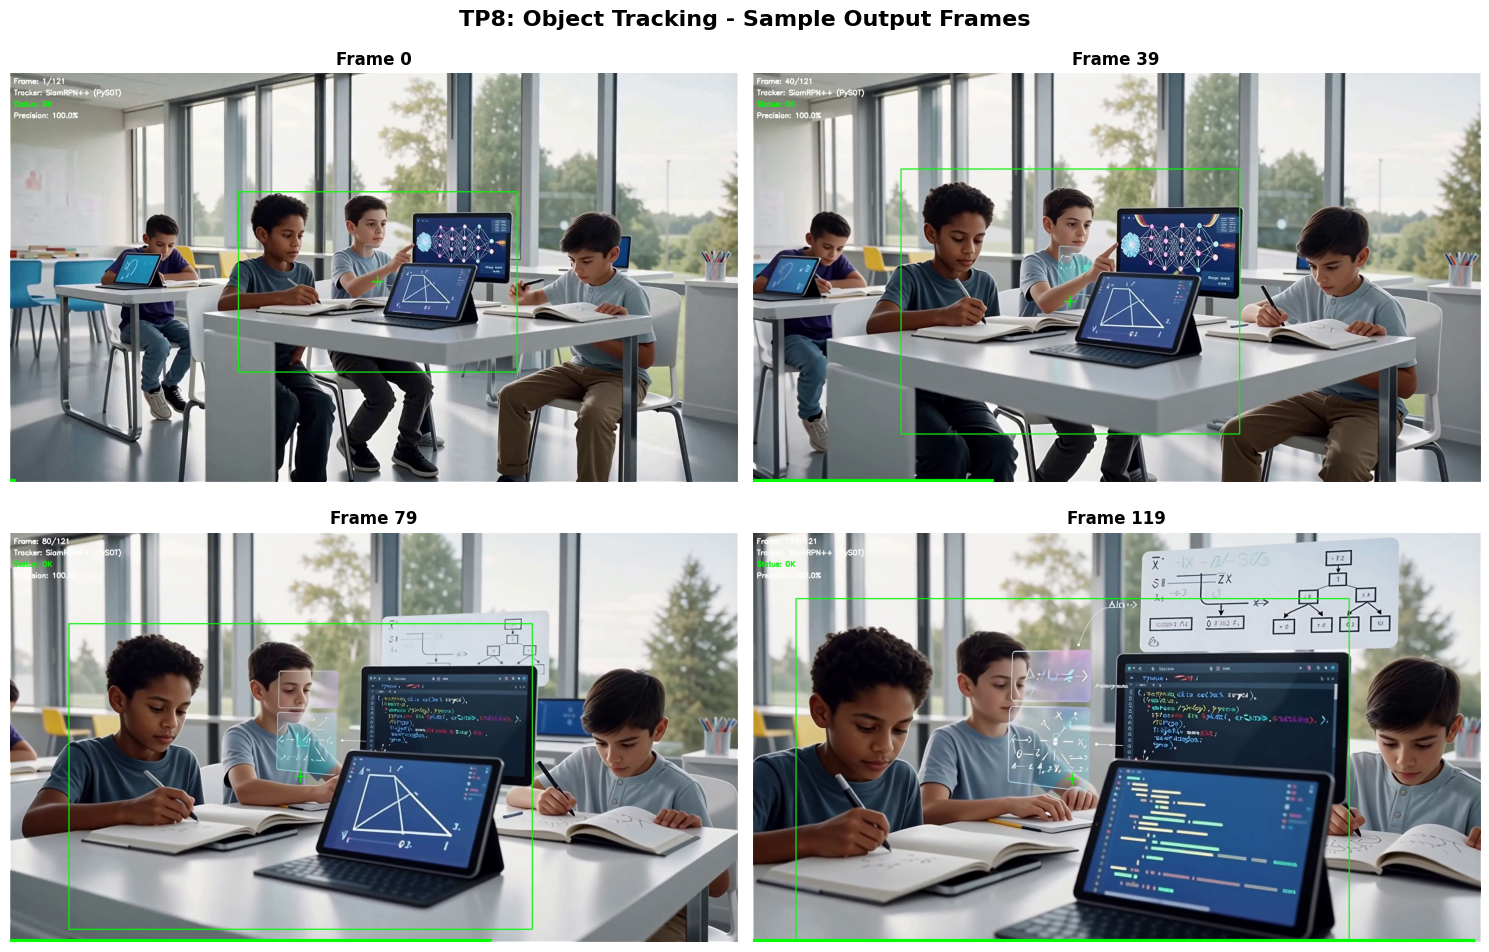

In [13]:
# ============================================================================
# PART 12: DISPLAY SAMPLE FRAMES (Optional)
# ============================================================================
print("\n[Optional] Extracting sample frames for preview...")

import numpy as np
import matplotlib.pyplot as plt

def extract_sample_frames(video_path, num_samples=4):
    """Extract evenly spaced sample frames from video"""
    cap = cv2.VideoCapture(str(video_path))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    sample_indices = np.linspace(0, total_frames-1, num_samples, dtype=int)
    frames = []
    
    for idx in sample_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame_rgb)
    
    cap.release()
    return frames, sample_indices

# Extract frames
sample_frames, indices = extract_sample_frames(VIDEO_OUTPUT, num_samples=4)

# Display
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (frame, idx) in enumerate(zip(sample_frames, indices)):
    axes[i].imshow(frame)
    axes[i].set_title(f'Frame {idx}', fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('TP8: Object Tracking - Sample Output Frames', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('/kaggle/working/sample_frames.png', dpi=100, bbox_inches='tight')
print("✓ Sample frames saved to: /kaggle/working/sample_frames.png")

print("\n" + "="*80)
print("ALL TASKS COMPLETED")
print("="*80)
print("\nFiles generated:")
print(f"  1. {VIDEO_OUTPUT} - Tracked video output")
print(f"  2. /kaggle/working/sample_frames.png - Sample frames preview")
print("\nYou can download these files from the Kaggle output section.")